In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

In [4]:
#loading the data from csv files
food = pd.read_csv("Data/year_msoa_grocery.csv")
deaths = pd.read_csv("Data/coviddeaths.csv")
imd = pd.read_csv("Data/imd2019_msoa_level_data.csv")
#Mergin all the data
merged = imd.merge(deaths, left_on="MSOAC", right_on="MSOA code").drop("MSOA code",axis=1)
df = merged.merge(food, left_on="MSOAC", right_on="area_id").drop(["March","April","May","June","July","LSOACOUNT","POPMID15"], axis=1)
df.rename(columns={'IMD19 SCORE':'IMD19_SCORE'}, inplace=True)
df.rename(columns={'Covid Deaths March to July':'Covid_deaths_march_july'}, inplace=True)
df.rename(columns={'age_65+':'age_65'}, inplace=True)
df.head()

,MSOAC,IMD19_SCORE,Covid_deaths_march_july,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,...,man_day,population,male,female,age_0_17,age_18_64,age_65,avg_age,area_sq_km,people_per_sq_km
0,E02000001,14.720484,4,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,...,103934,6687.0,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069
1,E02000002,34.767560,8,E02000002,397.651232,32.5,150.0,300.0,500.0,1020.0,...,9952,7379.0,3549.0,3830.0,2150.0,4151.0,1078.0,35.567286,2.16,3416.203704
2,E02000003,25.149726,10,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,...,19576,10720.0,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794
3,E02000004,23.560044,14,E02000004,347.481292,29.0,126.0,250.0,430.0,1000.0,...,10689,6536.0,3119.0,3417.0,1454.0,4044.0,1038.0,38.493115,2.48,2635.483871
4,E02000005,30.212965,7,E02000005,400.576688,32.5,150.0,296.0,500.0,1050.0,...,15071,9243.0,4478.0,4765.0,2678.0,5554.0,1011.0,34.156335,1.19,7767.226891


### 1. Data prepartion

To ensure that we only take areas that are well represented by the Tesco data set. We consider only areas with a representativeness norm bigger than 0.16. This leaves us with about 77% of all areas

In [5]:
df_rep = (df[df["representativeness_norm"]>0.16]).reset_index(drop=True)
len(df_rep)/len(df)
df_rep

,MSOAC,IMD19_SCORE,Covid_deaths_march_july,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,...,man_day,population,male,female,age_0_17,age_18_64,age_65,avg_age,area_sq_km,people_per_sq_km
0,E02000001,14.720484,4,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,...,103934,6687.0,3697.0,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069
1,E02000003,25.149726,10,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,...,19576,10720.0,5297.0,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794
2,E02000009,36.336546,7,E02000009,403.380279,32.5,160.0,300.0,500.0,1200.0,...,25814,10504.0,5095.0,5409.0,3192.0,6498.0,814.0,31.686215,0.96,10941.666667
3,E02000011,25.713969,12,E02000011,364.818183,28.5,142.0,250.0,450.0,1000.0,...,10824,6761.0,3318.0,3443.0,1774.0,4069.0,918.0,36.312380,1.60,4225.625000
4,E02000012,20.632166,8,E02000012,428.223742,37.0,170.0,300.0,500.0,1500.0,...,34091,10858.0,5377.0,5481.0,2906.0,6770.0,1182.0,34.166421,1.29,8417.054264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,E02006927,22.646314,10,E02006927,382.625053,34.0,160.0,300.0,500.0,1000.0,...,45833,9450.0,4455.0,4995.0,2282.0,5700.0,1468.0,37.527090,2.52,3750.000000
754,E02006928,20.761873,2,E02006928,372.224870,35.0,160.0,300.0,500.0,1000.0,...,81761,10126.0,4968.0,5158.0,2014.0,7735.0,377.0,29.600632,0.55,18410.909091
755,E02006929,27.115006,7,E02006929,348.194548,32.5,150.0,270.0,450.0,1000.0,...,50516,8464.0,4168.0,4296.0,1658.0,6109.0,697.0,33.643904,2.55,3319.215686
756,E02006930,20.582796,4,E02006930,347.600391,34.0,150.0,270.0,450.0,1000.0,...,39886,7537.0,3789.0,3748.0,1472.0,5436.0,629.0,33.773650,0.88,8564.772727


### 1. Creating the binary variable based on nutrition

Base on the recomondations from the WHO we will create a binary variable if the nutrition in the area is close to the recomondations. 

The following recomondations have been taken from this website https://www.who.int/publications/m/item/healthy-diet-factsheet394. 

"Less than 10% of total energy intake from free sugars (2, 7), which is equivalent to 50 g (or about 12 level teaspoons) for a person of healthy body weight consuming about 2000 calories per day, but ideally is less than
5% of total energy intake for additional health benefits (7). Free sugars are all sugars added to foods or drinks
by the manufacturer, cook or consumer, as well as sugars naturally present in honey, syrups, fruit juices and
fruit juice concentrates

Less than 30% of total energy intake from fats (1, 2, 3). Unsaturated fats (found in fish, avocado and nuts, and
in sunflower, soybean, canola and olive oils) are preferable to saturated fats (found in fatty meat, butter, palm
and coconut oil, cream, cheese, ghee and lard) and trans-fats of all kinds, including both industrially-produced
trans-fats (found in baked and fried foods, and pre-packaged snacks and foods, such as frozen pizza, pies,
cookies, biscuits, wafers, and cooking oils and spreads) and ruminant trans-fats (found in meat and dairy foods
from ruminant animals, such as cows, sheep, goats and camels). It is suggested that the intake of saturated
fats be reduced to less than 10% of total energy intake and trans-fats to less than 1% of total energy intake (5).
In particular, industrially-produced trans-fats are not part of a healthy diet and should be avoided (4, 6)."

Furthermore we will includ the criterion that less alcohol consumption is healthier. 



creating columns giving the percentages of energy_fat, energy_sugar, energy_saturate in refrence to the total energy consumption

In [7]:
def ratio(energy_total, energy_nutrient):
    return energy_nutrient/energy_total
df_rep["ratio_fat"] = df_rep.apply(lambda row: ratio(row["energy_tot"],row["energy_fat"]), axis=1)
df_rep["ratio_saturate"] = df_rep.apply(lambda row: ratio(row["energy_tot"],row["energy_saturate"]), axis=1)
df_rep["ratio_sugar"] = df_rep.apply(lambda row: ratio(row["energy_tot"],row["energy_sugar"]), axis=1)
df_rep.head()

,MSOAC,IMD19_SCORE,Covid_deaths_march_july,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,...,female,age_0_17,age_18_64,age_65,avg_age,area_sq_km,people_per_sq_km,ratio_fat,ratio_saturate,ratio_sugar
0,E02000001,14.720484,4,E02000001,323.180804,35.0,150.0,250.0,400.0,1000.0,...,2990.0,1018.0,4349.0,1320.0,43.910124,2.90,2305.862069,0.459817,0.182428,0.223769
1,E02000003,25.149726,10,E02000003,371.276702,30.0,140.0,250.0,450.0,1200.0,...,5423.0,2762.0,6649.0,1309.0,35.700466,2.14,5009.345794,0.444657,0.178014,0.260653
2,E02000009,36.336546,7,E02000009,403.380279,32.5,160.0,300.0,500.0,1200.0,...,5409.0,3192.0,6498.0,814.0,31.686215,0.96,10941.666667,0.441808,0.172274,0.224516
3,E02000011,25.713969,12,E02000011,364.818183,28.5,142.0,250.0,450.0,1000.0,...,3443.0,1774.0,4069.0,918.0,36.312380,1.60,4225.625000,0.453379,0.174168,0.248639
4,E02000012,20.632166,8,E02000012,428.223742,37.0,170.0,300.0,500.0,1500.0,...,5481.0,2906.0,6770.0,1182.0,34.166421,1.29,8417.054264,0.448406,0.179272,0.240974


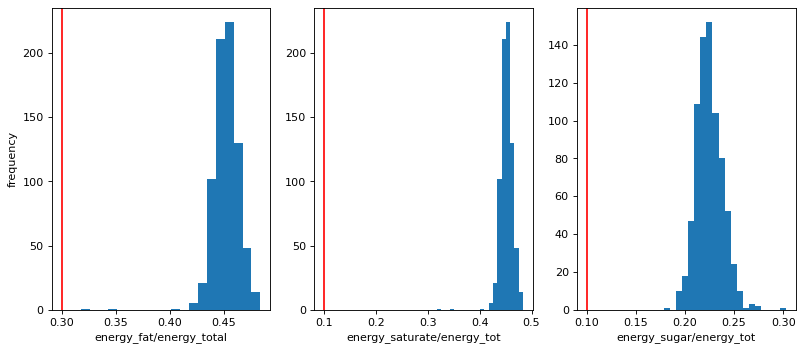

In [8]:
plt.figure(num=None, figsize=(12, 5), dpi=80, facecolor='w', edgecolor='k')
plt.subplot(131)
plt.hist(df_rep["ratio_fat"], bins=20)
plt.xlabel("energy_fat/energy_total")
plt.ylabel("frequency")
plt.axvline(0.30,c="r")

plt.subplot(132)
plt.hist(df_rep["ratio_fat"], bins=20)
plt.xlabel("energy_saturate/energy_tot")
plt.axvline(0.10,c="r")

plt.subplot(133)
plt.hist(df_rep["ratio_sugar"], bins=20)
plt.xlabel("energy_sugar/energy_tot")
plt.axvline(0.10,c="r");

As we can see from the plots above non of the areas satisfy the recommandations by the WHO. Therefore I classify 50% of the areas which are closest to the recommandations as healthy. This will be done by k nearest neighbors. For this the ratios will be converted to a distance measure, ratio observed - recommandation value = distance from recommandation. Then we can take the 50% which are closest to 0 in the 4 features :distance_fat, distance_sugar, distance_saturated, alcohole

In [9]:
def distance(nutrient,rec):
    return nutrient-rec
features = pd.DataFrame(columns=["distance_fat","distance_saturate","distance_sugar","alcohol"])
features["distance_fat"] = df_rep.apply(lambda row: distance(row["ratio_fat"],0.30), axis=1)
features["distance_saturate"] = df_rep.apply(lambda row: distance(row["ratio_saturate"],0.10), axis=1)
features["distance_sugar"] = df_rep.apply(lambda row: distance(row["ratio_sugar"],0.5), axis=1)
features["alcohol"] = df_rep["alcohol"]

In [10]:
#finding the nearest neigbors of the point [0,0,0,0]
from sklearn.neighbors import NearestNeighbors
half = int(len(features)/2)
optimum = np.array([0,0,0,0]).reshape(1, -1)
nbrs = NearestNeighbors(n_neighbors=half, algorithm='ball_tree').fit(features)
distances , indices = nbrs.kneighbors(optimum)

#crating healthy binary variabel base on the returned set from kneighbors
nearest_indices = indices.tolist()[0]

def healthy(index):
    return 1 if index in nearest_indices else 0

def rowIndex(row):
    return row.name

df_rep["rowIndex"] = df_rep.apply(lambda row: rowIndex(row), axis=1)
df_rep["healthy"] = df_rep.apply(lambda row: healthy(row["rowIndex"]), axis=1)

In [257]:
healthy = df_rep[df_rep["healthy"]==1][["people_per_sq_km","avg_age","age_0_17","age_18_64","age_65","IMD19_SCORE","healthy"]]
unhealthy = df_rep[df_rep["healthy"]==0][["people_per_sq_km","avg_age","age_0_17","age_18_64","age_65","IMD19_SCORE","healthy"]]

#population is not taken into account because MSOAS have by design the same number of inhabitatns

Formula:
healthy ~ population+people_per_sq_km+avg_age+age_0_17+age_18_64+age_65+IMD19_SCORE
n majority: 379
n minority: 379
Fitting Models on Balanced Samples: 100\100
Average Accuracy: 72.96%


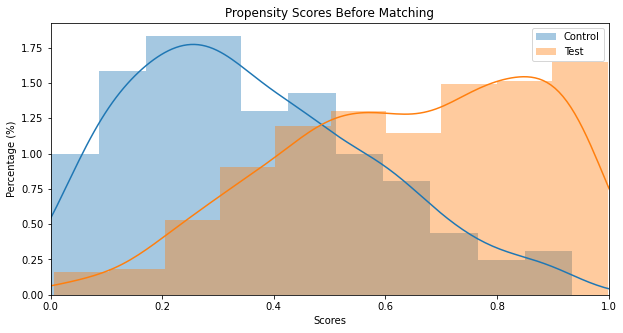

In [258]:
from pymatch.Matcher import Matcher
m = Matcher(unhealthy,healthy , yvar="healthy", exclude=[])
m.fit_scores(nmodels=100)
m.predict_scores()
m.plot_scores()

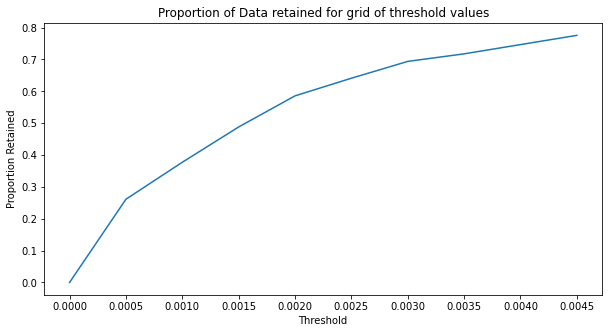

In [259]:
m.tune_threshold(method="random", rng=np.arange(0, .005, .0005))

In [260]:
m.matched_data.sort_values("match_id").head(6)

,population,people_per_sq_km,avg_age,age_0_17,age_18_64,age_65,IMD19_SCORE,healthy,scores,match_id,record_id
381,6761.0,4225.625000,36.312380,1774.0,4069.0,918.0,25.713969,1,0.766179,2,381
312,8213.0,3733.181818,42.216243,1746.0,4593.0,1874.0,23.474871,0,0.766601,2,312
382,10858.0,8417.054264,34.166421,2906.0,6770.0,1182.0,20.632166,1,0.873264,3,382
99,8164.0,4560.893855,35.487261,2192.0,4973.0,999.0,38.416360,0,0.876880,3,99
389,7711.0,5468.794326,40.553495,1792.0,4512.0,1407.0,8.446301,1,0.461816,10,389
308,9575.0,18413.461538,30.954569,2218.0,6918.0,439.0,23.273108,0,0.463209,10,308


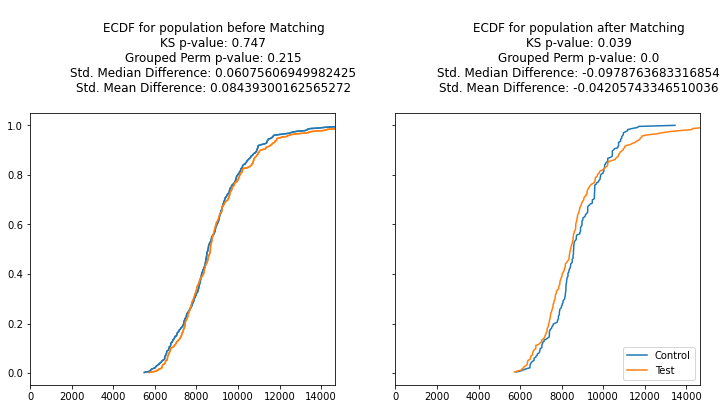

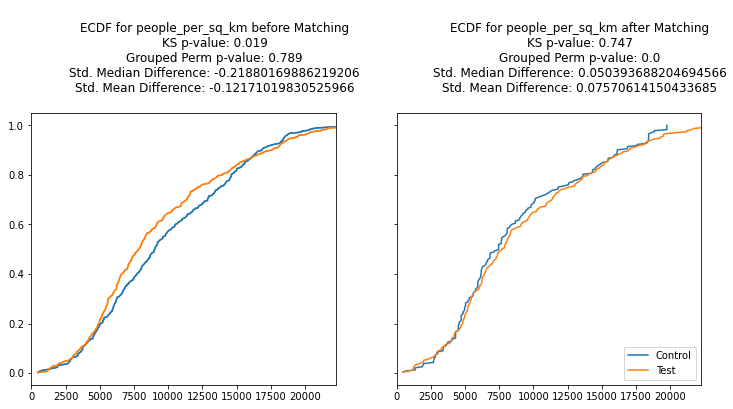

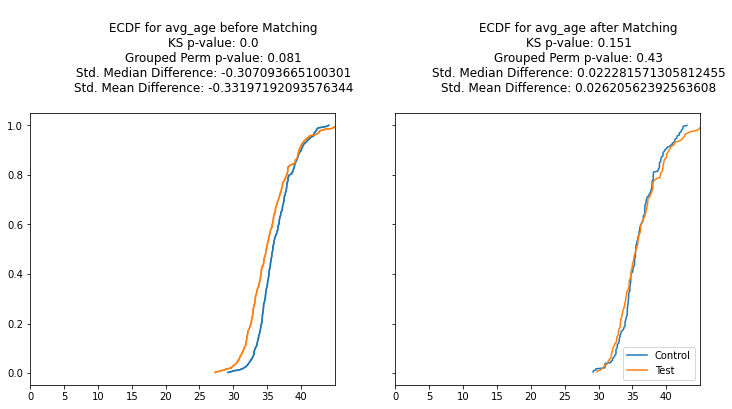

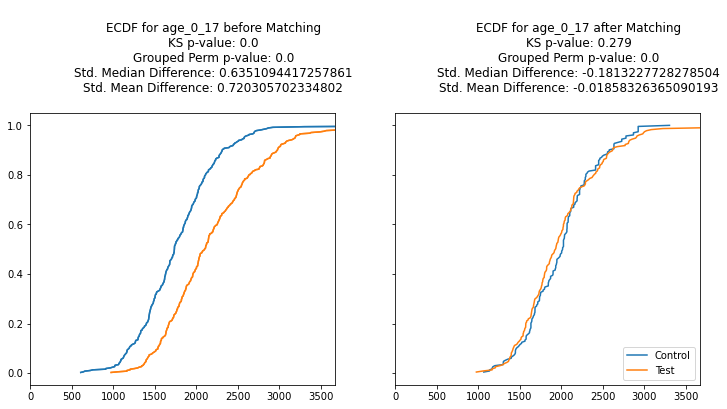

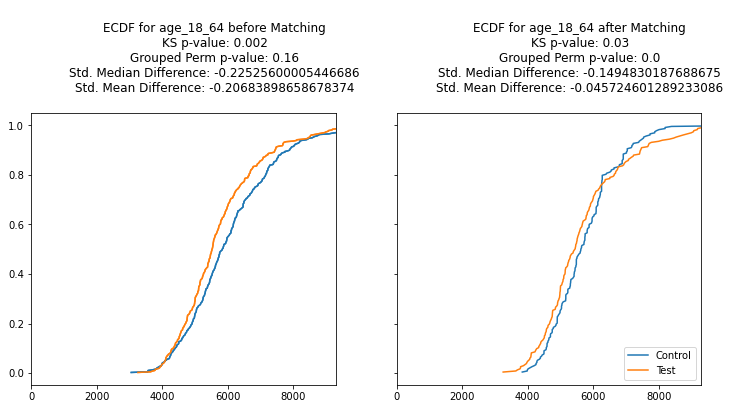

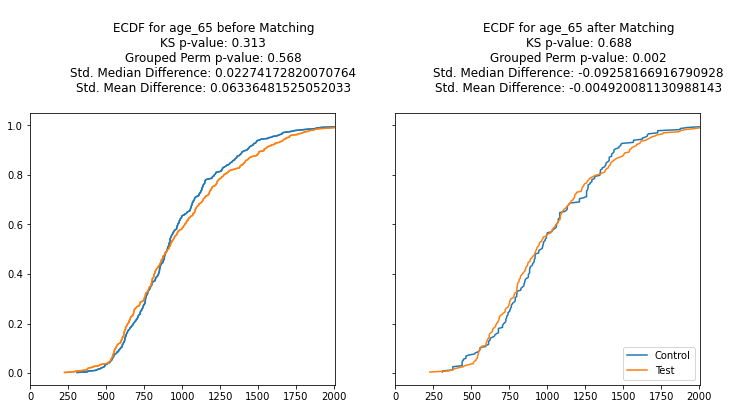

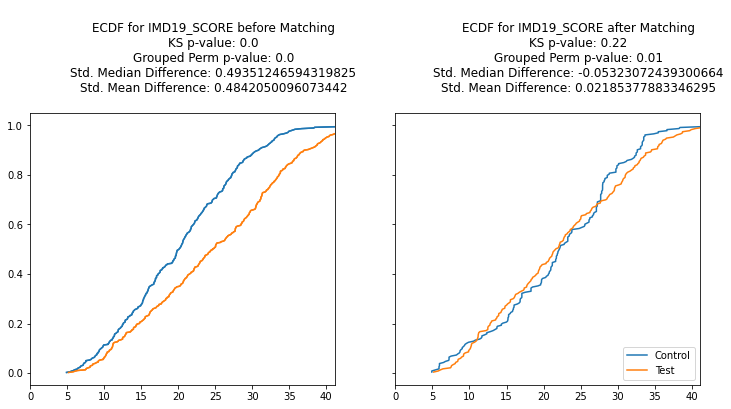

In [261]:
m.match(method="random", nmatches=1, threshold=0.0022)
cc = m.compare_continuous(return_table=True)

In [262]:
print(cc["grouped_chisqr_after"].sum()-cc["grouped_chisqr_before"].sum())
print(cc["grouped_chisqr_after"].sum()-cc["grouped_chisqr_before"].sum()) #i need to change that

-1.3709999999999998


In [263]:
df = pd.merge(df_rep,m.matched_data,how="left")
df_matched = (df[df["match_id"].notna()]).sort_values("match_id")
df_matched.head(6)

,MSOAC,IMD19_SCORE,Covid_deaths_march_july,area_id,weight,weight_perc2.5,weight_perc25,weight_perc50,weight_perc75,weight_perc97.5,...,people_per_sq_km,ratio_fat,ratio_saturate,ratio_sugar,rowIndex,healthy,Propensity_score,scores,match_id,record_id
3,E02000011,25.713969,12,E02000011,364.818183,28.5,142.0,250.0,450.0,1000.0,...,4225.625000,0.453379,0.174168,0.248639,3,1,0.855617,0.766179,2.0,381.0
732,E02000895,23.474871,16,E02000895,399.868703,40.0,175.0,300.0,500.0,1200.0,...,3733.181818,0.435179,0.173418,0.222442,651,0,0.707558,0.766601,2.0,312.0
22,E02000032,8.446301,6,E02000032,373.395385,32.5,151.0,296.0,500.0,1000.0,...,5468.794326,0.450067,0.177754,0.228044,20,1,0.424810,0.461816,10.0,389.0
722,E02000888,23.273108,2,E02000888,350.001211,36.0,150.0,250.0,450.0,1000.0,...,18413.461538,0.460896,0.179124,0.221364,645,0,0.755884,0.463209,10.0,308.0
723,E02000888,23.273108,2,E02000888,350.001211,36.0,150.0,250.0,450.0,1000.0,...,18413.461538,0.460896,0.179124,0.221364,645,0,0.755884,0.463209,11.0,308.0
25,E02000035,13.702045,24,E02000035,394.493131,40.0,170.0,300.0,500.0,1000.0,...,6544.274809,0.464282,0.182531,0.223382,23,1,0.335484,0.461788,11.0,390.0


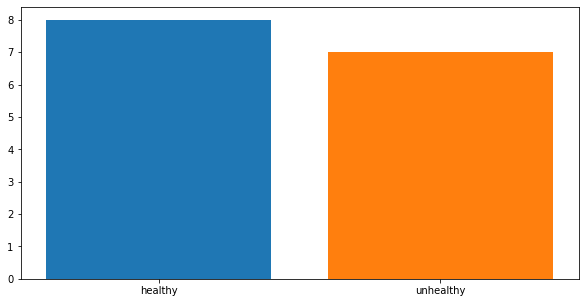

In [264]:
import statistics
fig, ax = plt.subplots()
healthy = statistics.median(df_matched[df_matched["healthy"]==1]["Covid_deaths_march_july"])
unhealthy = statistics.median(df_matched[df_matched["healthy"]==0]["Covid_deaths_march_july"])
ax = plt.bar("healthy",healthy)
ax = plt.bar("unhealthy",unhealthy)

In [265]:
#Computing the average treatment effect

In [266]:
iter = list(df_matched["match_id"].unique())

In [267]:
ATE = 0
for match in list(df_matched["match_id"].unique()) :
    pair = df_matched[df_matched["match_id"]==match]
    healthy = pair[pair["healthy"]==1]
    unhealthy = pair[pair["healthy"]==0]

    ATE += healthy["Covid_deaths_march_july"].values[0]-unhealthy["Covid_deaths_march_july"].values[0]
ATE

210

In [256]:
for cols in df_rep:
    print(cols)

MSOAC
IMD19_SCORE
Covid_deaths_march_july
area_id
weight
weight_perc2.5
weight_perc25
weight_perc50
weight_perc75
weight_perc97.5
weight_std
weight_ci95
volume
volume_perc2.5
volume_perc25
volume_perc50
volume_perc75
volume_perc97.5
volume_std
volume_ci95
fat
fat_perc2.5
fat_perc25
fat_perc50
fat_perc75
fat_perc97.5
fat_std
fat_ci95
saturate
saturate_perc2.5
saturate_perc25
saturate_perc50
saturate_perc75
saturate_perc97.5
saturate_std
saturate_ci95
salt
salt_perc2.5
salt_perc25
salt_perc50
salt_perc75
salt_perc97.5
salt_std
salt_ci95
sugar
sugar_perc2.5
sugar_perc25
sugar_perc50
sugar_perc75
sugar_perc97.5
sugar_std
sugar_ci95
protein
protein_perc2.5
protein_perc25
protein_perc50
protein_perc75
protein_perc97.5
protein_std
protein_ci95
carb
carb_perc2.5
carb_perc25
carb_perc50
carb_perc75
carb_perc97.5
carb_std
carb_ci95
fibre
fibre_perc2.5
fibre_perc25
fibre_perc50
fibre_perc75
fibre_perc97.5
fibre_std
fibre_ci95
alcohol
alcohol_perc2.5
alcohol_perc25
alcohol_perc50
alcohol_perc75
al